In [14]:
import pandas as pd
df = pd.read_csv('sequences_df.csv')
print("DataFrame loaded successfully from 'sequences_df.csv':")


DataFrame loaded successfully from 'sequences_df.csv':


In [3]:
df

,experiment_name,model_name,sequence
0,sequence_generation_10,deepseek-chat-V3,"[3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 2, 7, 3, 5, 9,..."
1,sequence_generation_10,deepseek-chat-V3,"[3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 2, 5, 7, 3, 9,..."
2,sequence_generation_10,deepseek-chat-V3,"[3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 3, 7, 2, 9, 5,..."
3,sequence_generation_10,deepseek-chat-V3,"[3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 2, 5, 7, 3, 9,..."
4,sequence_generation_10,deepseek-chat-V3,"[3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 3, 7, 2, 9, 5,..."
...,...,...,...
8795,sequence_generation_10,prng,"[7, 8, 8, 4, 2, 2, 3, 7, 6, 1, 4, 9, 7, 10, 10..."
8796,sequence_generation_10,prng,"[3, 5, 1, 4, 10, 7, 9, 10, 8, 3, 3, 5, 9, 7, 5..."
8797,sequence_generation_10,prng,"[7, 9, 2, 4, 9, 7, 5, 4, 2, 7, 8, 1, 5, 5, 10,..."
8798,sequence_generation_10,prng,"[3, 6, 1, 8, 6, 6, 1, 2, 7, 8, 4, 8, 2, 8, 6, ..."


In [4]:
print(df.groupby('model_name').size())

model_name
deepseek-chat-V3                  800
deepseek-chat-V3.2                800
gemini-2.5-flash                  800
gemini-2.5-flash-preview-05-20    800
gpt-3.5-turbo-0125                800
gpt-4.1                           800
gpt-4.1-mini                      800
gpt-4.1-nano                      800
gpt-5-2025-08-07                  800
gpt-5-nano-2025-08-07             800
prng                              800
dtype: int64


In [9]:
import random
import numpy as np
import torch
import os

def set_global_seed(seed):
    # 1. Standard python and numpy seeds
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # Fixes arbitrary hash seed for dictionaries

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

In [12]:
max_len_options = list(range(10, 51, 5))+ [5]
bag_size_options = list(range(5, 0, -1))
learning_rate = 0.001


batch_size = 16
embed_dim = 128
hidden_dim = 128
epochs = 20


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random



def parse_seq(x):
    if isinstance(x, list): return x
    try: return [int(i) for i in str(x).replace('[','').replace(']','').split(',') if i.strip().isdigit()]
    except: return []

df['parsed_seq'] = df['sequence'].apply(parse_seq)
df_clean = df[df['parsed_seq'].map(len) >= 5].copy()

# --- 3. Classes ---
class MultiShotDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MultiShotLSTM(nn.Module):
    def __init__(self, num_classes, vocab_size=12, embed_dim=32, hidden_dim=64):
        super(MultiShotLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        B, N, L = x.shape
        x_flat = x.view(B * N, L)
        emb = self.embedding(x_flat)
        _, (hidden, _) = self.lstm(emb)
        last_hidden = hidden[-1]
        hidden_grouped = last_hidden.view(B, N, -1)
        bag_feature = torch.mean(hidden_grouped, dim=1)
        logits = self.fc(bag_feature)
        return logits

# --- 4. Main Training Loop ---
results = []

for current_max_len in max_len_options:
    for current_bag_size in bag_size_options:

        # Create Bags
        X_bags = []
        y_bags = []
        grouped = df_clean.groupby('model_name')

        for model_name, group in grouped:
            seqs = group['parsed_seq'].tolist()
            padded_seqs = np.zeros((len(seqs), current_max_len), dtype=int)
            for i, s in enumerate(seqs):
                l = min(len(s), current_max_len)
                padded_seqs[i, :l] = s[:l]

            if len(seqs) < current_bag_size:
                continue

            num_bags = len(seqs) // current_bag_size
            if num_bags > 0:
                bags = padded_seqs[:num_bags * current_bag_size].reshape(num_bags, current_bag_size, current_max_len)
                X_bags.append(bags)
                y_bags.extend([model_name] * num_bags)

        if not X_bags or len(np.unique(y_bags)) < 2:
            continue

        X_data = np.concatenate(X_bags, axis=0)
        y_data = np.array(y_bags)

        le = LabelEncoder()
        y_encoded = le.fit_transform(y_data)

        # Check for sufficient samples for splitting
        if np.min(pd.Series(y_encoded).value_counts()) < 2:
            continue

        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        train_ds = MultiShotDataset(X_train, y_train)
        test_ds = MultiShotDataset(X_test, y_test)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        max_idx = np.max(X_data)
        vocab_size = 11

        model = MultiShotLSTM(num_classes=len(le.classes_), vocab_size=vocab_size,
                              embed_dim=embed_dim, hidden_dim=hidden_dim).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training (Silent Loop)
        model.train()
        for epoch in range(epochs):
            for X_b, y_b in train_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)
                optimizer.zero_grad()
                outputs = model(X_b)
                loss = criterion(outputs, y_b)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_b, y_b in test_loader:
                X_b = X_b.to(device)
                outputs = model(X_b)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_b.numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=le.classes_, output_dict=True, zero_division=0)

        results.append({
            'MAX_LEN': current_max_len,
            'BAG_SIZE': current_bag_size,
            'accuracy': accuracy,
            'f1_macro': report['macro avg']['f1-score'],
            'report': report,
            'actual_labels': all_labels,
            'predicted_labels': all_preds
        })

        print(f"Finished MAX_LEN: {current_max_len}, BAG_SIZE: {current_bag_size} -> Test Accuracy: {accuracy:.4f}")


if results:
    results_df = pd.DataFrame(results)

    print("\n" + "="*30)
    print("GRID SEARCH RESULTS")
    print("="*30)
    print(results_df[['MAX_LEN', 'BAG_SIZE', 'accuracy', 'f1_macro']])

    best_idx = results_df['f1_macro'].idxmax()
    best_result = results_df.loc[best_idx]

    print("\nBest Performing Hyperparameters:")
    print(best_result[['MAX_LEN', 'BAG_SIZE', 'accuracy', 'f1_macro']])
else:
    print("No valid results generated.")

Finished MAX_LEN: 10, BAG_SIZE: 5 -> Test Accuracy: 0.9375
Finished MAX_LEN: 10, BAG_SIZE: 4 -> Test Accuracy: 0.9273
Finished MAX_LEN: 10, BAG_SIZE: 3 -> Test Accuracy: 0.9044
Finished MAX_LEN: 10, BAG_SIZE: 2 -> Test Accuracy: 0.8682
Finished MAX_LEN: 10, BAG_SIZE: 1 -> Test Accuracy: 0.7409
Finished MAX_LEN: 15, BAG_SIZE: 5 -> Test Accuracy: 0.9574
Finished MAX_LEN: 15, BAG_SIZE: 4 -> Test Accuracy: 0.9364
Finished MAX_LEN: 15, BAG_SIZE: 3 -> Test Accuracy: 0.9215
Finished MAX_LEN: 15, BAG_SIZE: 2 -> Test Accuracy: 0.8727
Finished MAX_LEN: 15, BAG_SIZE: 1 -> Test Accuracy: 0.7568
Finished MAX_LEN: 20, BAG_SIZE: 5 -> Test Accuracy: 0.9545
Finished MAX_LEN: 20, BAG_SIZE: 4 -> Test Accuracy: 0.9364
Finished MAX_LEN: 20, BAG_SIZE: 3 -> Test Accuracy: 0.9454
Finished MAX_LEN: 20, BAG_SIZE: 2 -> Test Accuracy: 0.8761
Finished MAX_LEN: 20, BAG_SIZE: 1 -> Test Accuracy: 0.7665
Finished MAX_LEN: 25, BAG_SIZE: 5 -> Test Accuracy: 0.9489
Finished MAX_LEN: 25, BAG_SIZE: 4 -> Test Accuracy: 0.95

In [ ]:
pivot_table_f1 = results_df.pivot_table(index='MAX_LEN', columns='BAG_SIZE', values='f1_macro')
print("Pivot Table for f1_macro:")
print(pivot_table_f1)

Pivot Table for f1_macro:
BAG_SIZE         1         2         3         4         5
MAX_LEN                                                   
5         0.653553  0.790167  0.862925  0.892716  0.929462
10        0.739467  0.868252  0.905277  0.927027  0.938095
15        0.755525  0.872359  0.921600  0.936375  0.957400
20        0.763653  0.873889  0.945212  0.936471  0.954627
25        0.790485  0.836319  0.943529  0.949846  0.949121
30        0.789238  0.873463  0.916262  0.949794  0.948994
35        0.794159  0.886060  0.894971  0.910842  0.936513
40        0.783854  0.858301  0.909583  0.917870  0.942584
45        0.751043  0.852719  0.911028  0.933492  0.899011
50        0.779896  0.878039  0.892731  0.904115  0.910001


In [ ]:
pivot_table_accuracy = results_df.pivot_table(index='MAX_LEN', columns='BAG_SIZE', values='accuracy')
pivot_table_f1 = results_df.pivot_table(index='MAX_LEN', columns='BAG_SIZE', values='f1_macro')

print("Pivot Table for Accuracy:")
print(pivot_table_accuracy)
print("\nPivot Table for f1_macro:")
print(pivot_table_f1)

Pivot Table for Accuracy:
BAG_SIZE         1         2         3         4         5
MAX_LEN                                                   
5         0.654545  0.790909  0.863481  0.893182  0.928977
10        0.740909  0.868182  0.904437  0.927273  0.937500
15        0.756818  0.872727  0.921502  0.936364  0.957386
20        0.766477  0.876136  0.945392  0.936364  0.954545
25        0.792045  0.839773  0.943686  0.950000  0.948864
30        0.790909  0.875000  0.916382  0.950000  0.948864
35        0.794886  0.885227  0.895904  0.911364  0.937500
40        0.785795  0.856818  0.909556  0.918182  0.943182
45        0.751705  0.853409  0.911263  0.934091  0.900568
50        0.779545  0.879545  0.894198  0.904545  0.911932

Pivot Table for f1_macro:
BAG_SIZE         1         2         3         4         5
MAX_LEN                                                   
5         0.653553  0.790167  0.862925  0.892716  0.929462
10        0.739467  0.868252  0.905277  0.927027  0.938095
15 

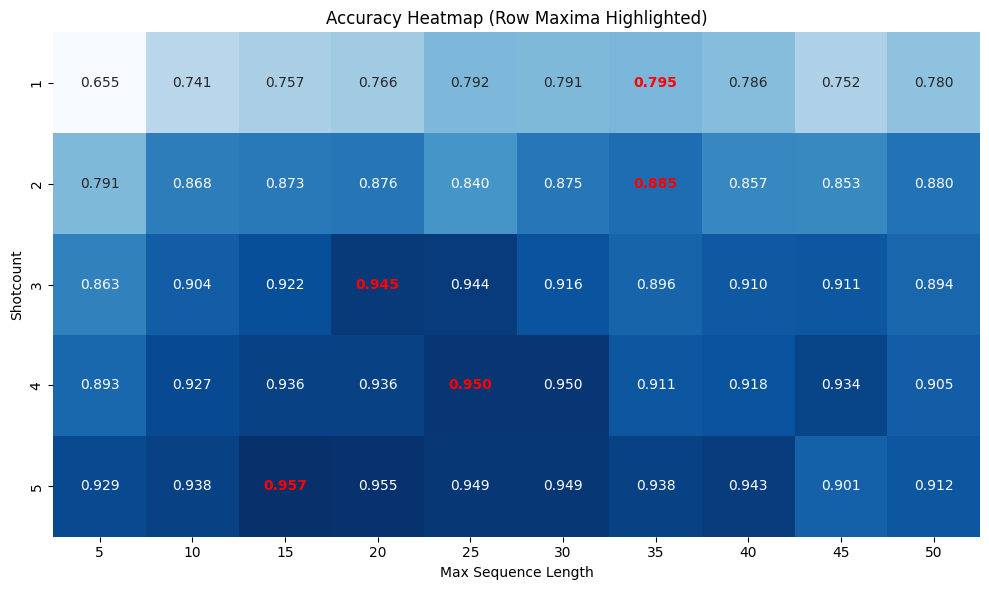

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Flip the axes
df_accuracy = pivot_table_accuracy.T

def get_row_max_highlight_positions(df_data):
    highlight_matrix = np.full(df_data.shape, False, dtype=bool)
    for i in range(df_data.shape[0]):
        row_max_val = df_data.iloc[i, :].max()
        first_max_col_idx = np.where(df_data.iloc[i, :] == row_max_val)[0][0]
        highlight_matrix[i, first_max_col_idx] = True
    return highlight_matrix

highlight_accuracy_matrix = get_row_max_highlight_positions(df_accuracy)

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df_accuracy, annot=True, cmap='Blues', fmt=".3f", ax=ax, cbar=False)

ax.set_title('Accuracy Heatmap (Row Maxima Highlighted)')
ax.set_ylabel('Shotcount')
ax.set_xlabel('Max Sequence Length')

for text_obj, is_highlight in zip(ax.texts, highlight_accuracy_matrix.flatten()):
    if is_highlight:
        text_obj.set_color('red')
        text_obj.set_weight('bold')

plt.tight_layout()
plt.savefig('accuracy_heatmap.eps', format='eps', bbox_inches='tight')
plt.show()

Saved confusion_matrix_maxlen50_shotcount1.eps


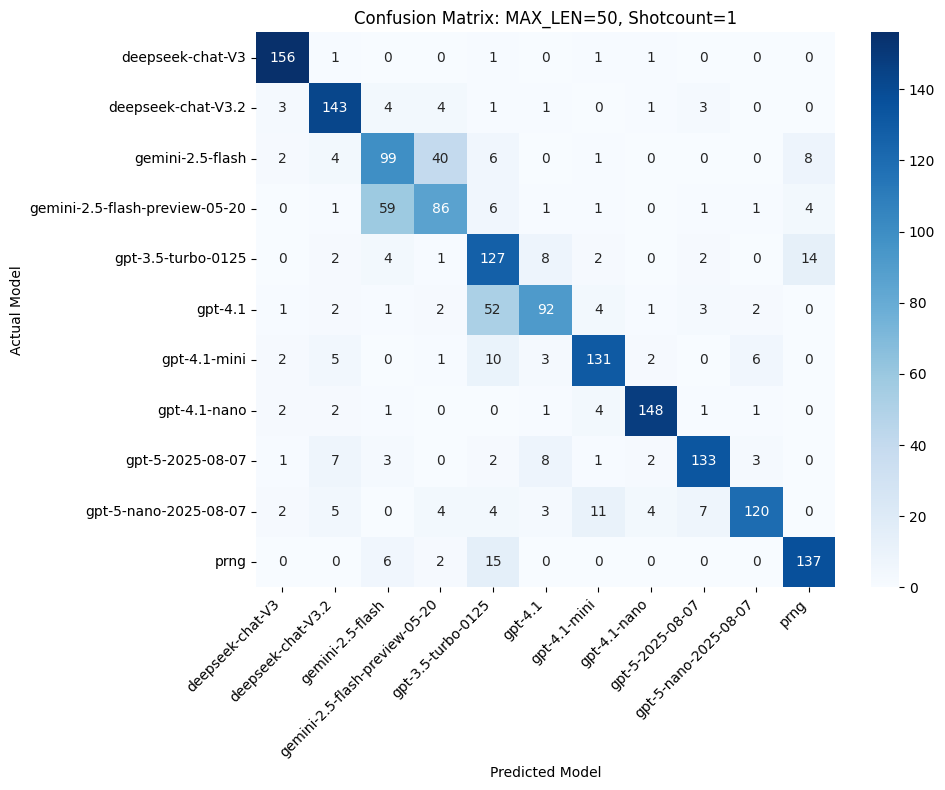

Saved confusion_matrix_maxlen15_shotcount5.eps


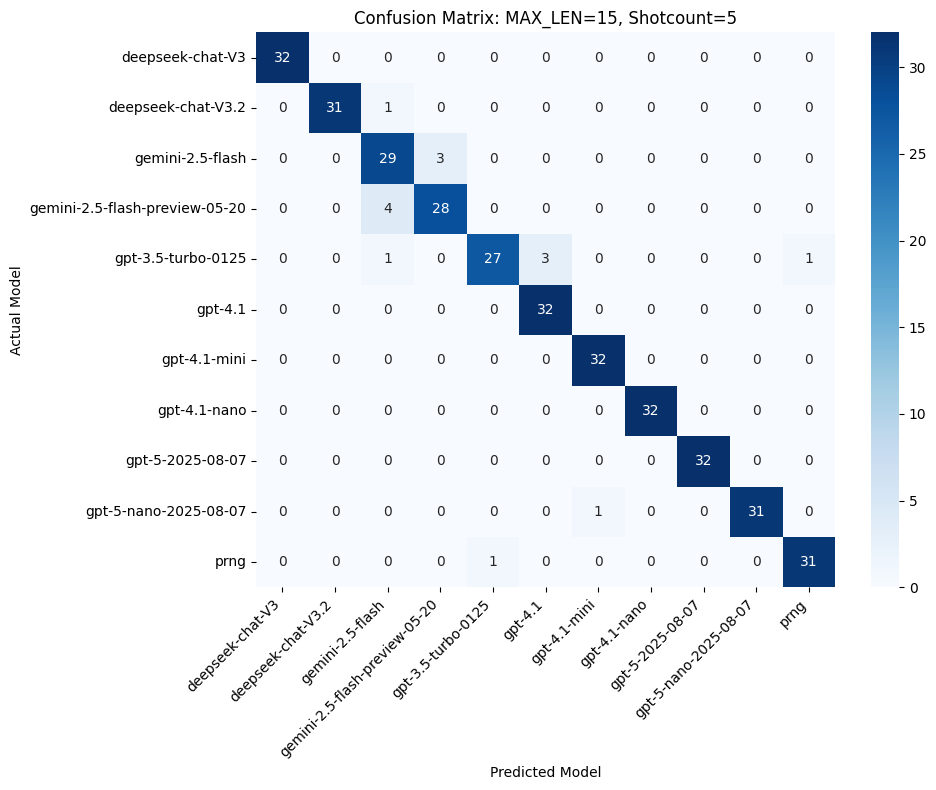

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_and_save_confusion_matrix(max_len, bag_size, results_df, le):
    specific_result = results_df[
        (results_df['MAX_LEN'] == max_len) &
        (results_df['BAG_SIZE'] == bag_size)
    ]

    if specific_result.empty:
        print(f"No results found for MAX_LEN={max_len}, BAG_SIZE={bag_size}")
        return

    actual_labels = specific_result.iloc[0]['actual_labels']
    predicted_labels = specific_result.iloc[0]['predicted_labels']

    cm = confusion_matrix(actual_labels, predicted_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    title = f"Confusion Matrix: MAX_LEN={max_len}, Shotcount={bag_size}"
    plt.title(title)
    plt.xlabel("Predicted Model")
    plt.ylabel("Actual Model")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f"confusion_matrix_maxlen{max_len}_shotcount{bag_size}.eps"
    plt.savefig(filename, format='eps', bbox_inches='tight')
    print(f"Saved {filename}")
    plt.show()

# Configurations to plot
configurations = [
    {'MAX_LEN': 50, 'BAG_SIZE': 1},
    {'MAX_LEN': 15, 'BAG_SIZE': 5}
]

for config in configurations:
    plot_and_save_confusion_matrix(config['MAX_LEN'], config['BAG_SIZE'], results_df, le)


In [ ]:
from sklearn.metrics import classification_report

def print_classification_report(max_len, bag_size, results_df, le):
    specific_result = results_df[
        (results_df['MAX_LEN'] == max_len) &
        (results_df['BAG_SIZE'] == bag_size)
    ]

    if specific_result.empty:
        print(f"No results found for MAX_LEN={max_len}, BAG_SIZE={bag_size}")
        return

    actual_labels = specific_result.iloc[0]['actual_labels']
    predicted_labels = specific_result.iloc[0]['predicted_labels']

    print(f"\n--- Classification Report for MAX_LEN={max_len}, Shotcount={bag_size} ---")
    print(classification_report(actual_labels, predicted_labels, target_names=le.classes_))

configurations = [
    {'MAX_LEN': 50, 'BAG_SIZE': 1},
    {'MAX_LEN': 15, 'BAG_SIZE': 5}
]

for config in configurations:
    print_classification_report(config['MAX_LEN'], config['BAG_SIZE'], results_df, le)



--- Classification Report for MAX_LEN=50, Shotcount=1 ---
                                precision    recall  f1-score   support

              deepseek-chat-V3       0.92      0.97      0.95       160
            deepseek-chat-V3.2       0.83      0.89      0.86       160
              gemini-2.5-flash       0.56      0.62      0.59       160
gemini-2.5-flash-preview-05-20       0.61      0.54      0.57       160
            gpt-3.5-turbo-0125       0.57      0.79      0.66       160
                       gpt-4.1       0.79      0.57      0.66       160
                  gpt-4.1-mini       0.84      0.82      0.83       160
                  gpt-4.1-nano       0.93      0.93      0.93       160
              gpt-5-2025-08-07       0.89      0.83      0.86       160
         gpt-5-nano-2025-08-07       0.90      0.75      0.82       160
                          prng       0.84      0.86      0.85       160

                      accuracy                           0.78      1760
   